In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Attention
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding


In [3]:
plt.rcParams["font.sans-serif"] = ["SimHei"] # 解决中文字符乱码的问题
plt.rcParams["axes.unicode_minus"] = False # 正常显示负号

In [4]:
# 读取数据
df = pd.read_excel('combine_df.xlsx')

In [5]:
df.head()

,id,name,alias,actor,url,director_x,vote,des,label,year,rating,category,duration,tag,lables
0,156,事先张扬的身后事件,排队上天堂(台) / 罗珊娜的坟墓,让·雷诺/梅塞迪丝·鲁尔/波利·沃克/马克·法兰科/特雷弗·皮科克/菲·雷普利/乔治·罗西/...,https://img1.doubanio.com/view/photo/s_ratio_p...,保罗·韦兰德,2415,马赛洛（让·雷诺 Jean Reno 饰）是小镇上知名的好好先生，可命运待他却不厚道，在孩子...,意大利/喜剧/爱情/1997/美国/排队上天堂/温情/剧情,1997,8.1,剧情/喜剧/爱情,98,意大利/喜剧/爱情/1997/美国/排队上天堂/温情/剧情,0
1,1418,意大利式结婚,啼笑姻缘路 / 意大利式婚礼 / 结婚进行曲,索菲娅·罗兰/马塞洛·马斯楚安尼/阿尔多·普利西/泰克拉·斯卡拉诺/玛丽卢·托洛,https://img3.doubanio.com/view/photo/s_ratio_p...,维托里奥·德西卡,2007,一次意外中，多米尼克（马塞洛·马斯楚安尼 Marcello Mastroianni 饰）救下...,意大利/意大利电影/喜剧/索菲娅·罗兰/爱情/德·西卡/1964/VittorioDeSica,1964,8.1,剧情/喜剧/爱情,102,意大利/意大利电影/喜剧/索菲娅·罗兰/爱情/德·西卡/1964/VittorioDeSica,0
2,1611,浪漫年代,选择的亲密关系 / 亲合力,无,无,保罗·塔维亚尼/维托里奥·塔维亚尼,132,嘉乐塔（伊莎贝尔·于佩尔 Isabelle Huppert 饰）和爱德华（让·雨果·安格拉德...,意大利/意大利电影/法国/IsabelleHuppert/爱情/歌德/Isabelle_Hu...,1996,7.2,剧情/喜剧/爱情,98,意大利/意大利电影/法国/IsabelleHuppert/爱情/歌德/Isabelle_Hu...,0
3,1891,工作,年轻人的烦恼 / 谋职记,图利奥·凯齐赫,https://img3.doubanio.com/view/photo/s_ratio_p...,埃曼诺·奥尔米,1738,导演奥米建立风格和信誉的早期写实作品，叙述了一个15岁乡下男孩到米兰的大公司谋职的经过。男孩...,意大利/意大利电影/埃曼诺·奥尔米/新写实主义/1960s/1961/黑白/Ermanno_...,1961,8.4,剧情/喜剧,93,意大利/意大利电影/埃曼诺·奥尔米/新写实主义/1960s/1961/黑白/Ermanno_...,0
4,2018,擦鞋童,无,弗朗科·英特朗吉/里纳尔多·斯默东尼,https://img3.doubanio.com/view/photo/s_ratio_p...,维托里奥·德西卡,2390,故事发生在二战后的意大利，战争对于国家和人民的伤害无法估量，短时间内造成的痛苦和破坏，需要更...,意大利/德·西卡/新现实主义/意大利电影/儿童/1946/奥斯卡最佳外语片/维托里奥·德·西卡,1946,8.5,剧情,93,意大利/德·西卡/新现实主义/意大利电影/儿童/1946/奥斯卡最佳外语片/维托里奥·德·西卡,0


**电影时长分布图**

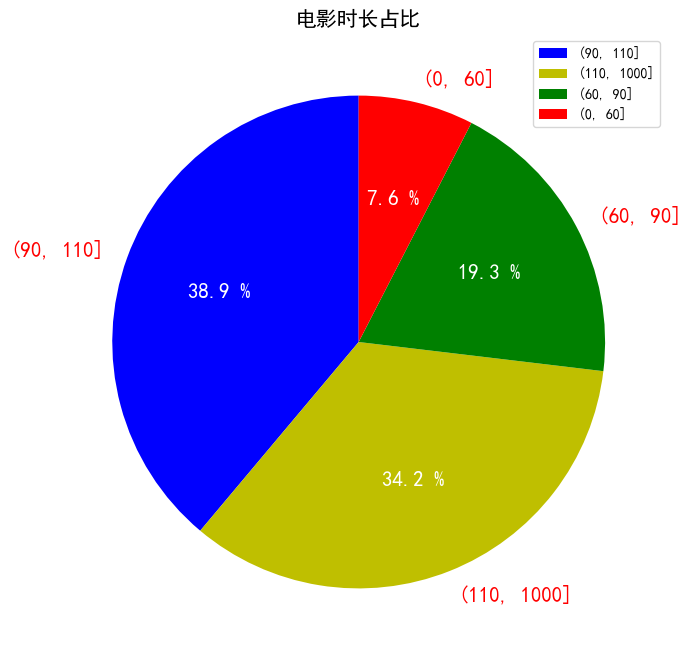

In [6]:
data = pd.cut(df["duration"], [0,60,90,110,1000]).value_counts() # 数据离散化
y = data.values
y = y/sum(y) # 归一化，不进行的话系统会自动进行

plt.figure(figsize = (8,8))
plt.title("电影时长占比",fontsize = 15)
patches,l_text,p_text = plt.pie(y, labels = data.index, autopct = "%.1f %%", colors = "bygr", startangle = 90)

for i in p_text: # 通过返回值设置饼图内部字体
    i.set_size(15)
    i.set_color('w')

for i in l_text: # 通过返回值设置饼图外部字体
    i.set_size(15)
    i.set_color('r')
    
plt.legend() # 图例
plt.show()

### 电影评分分布图

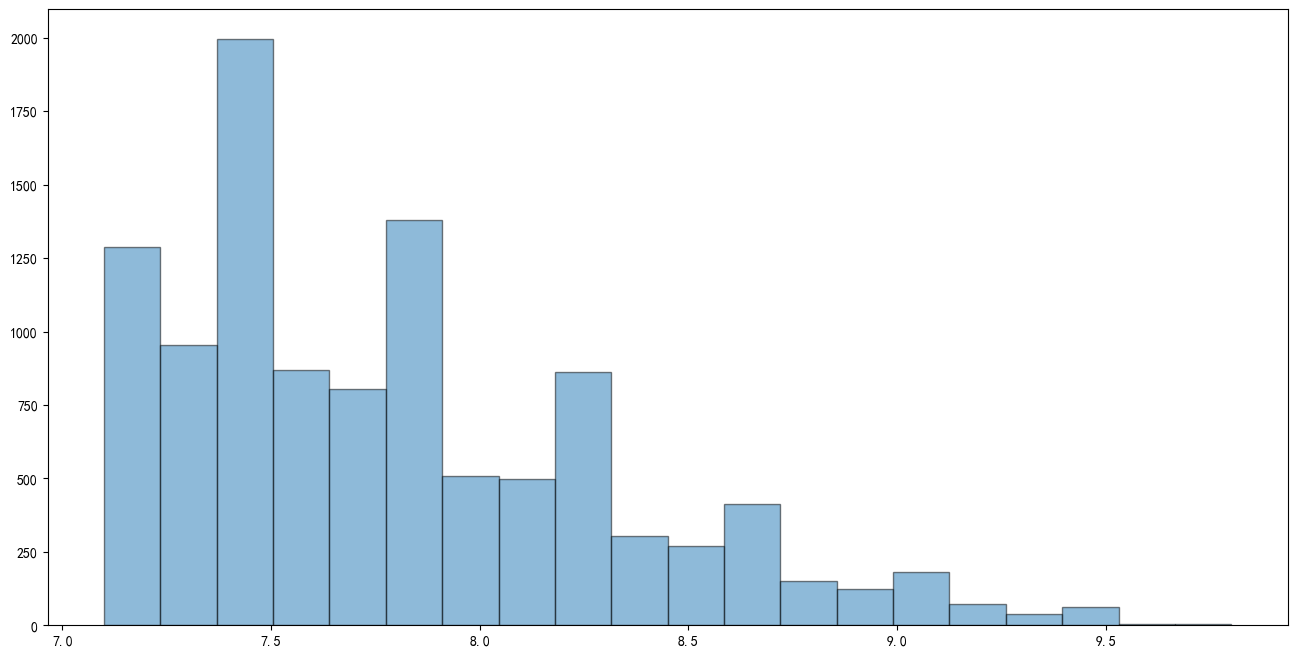

In [7]:
plt.figure(figsize = (16,8))
plt.hist(df["rating"], bins = 20, edgecolor = 'k',alpha = 0.5)
plt.show()

### 电影评分的双轴图

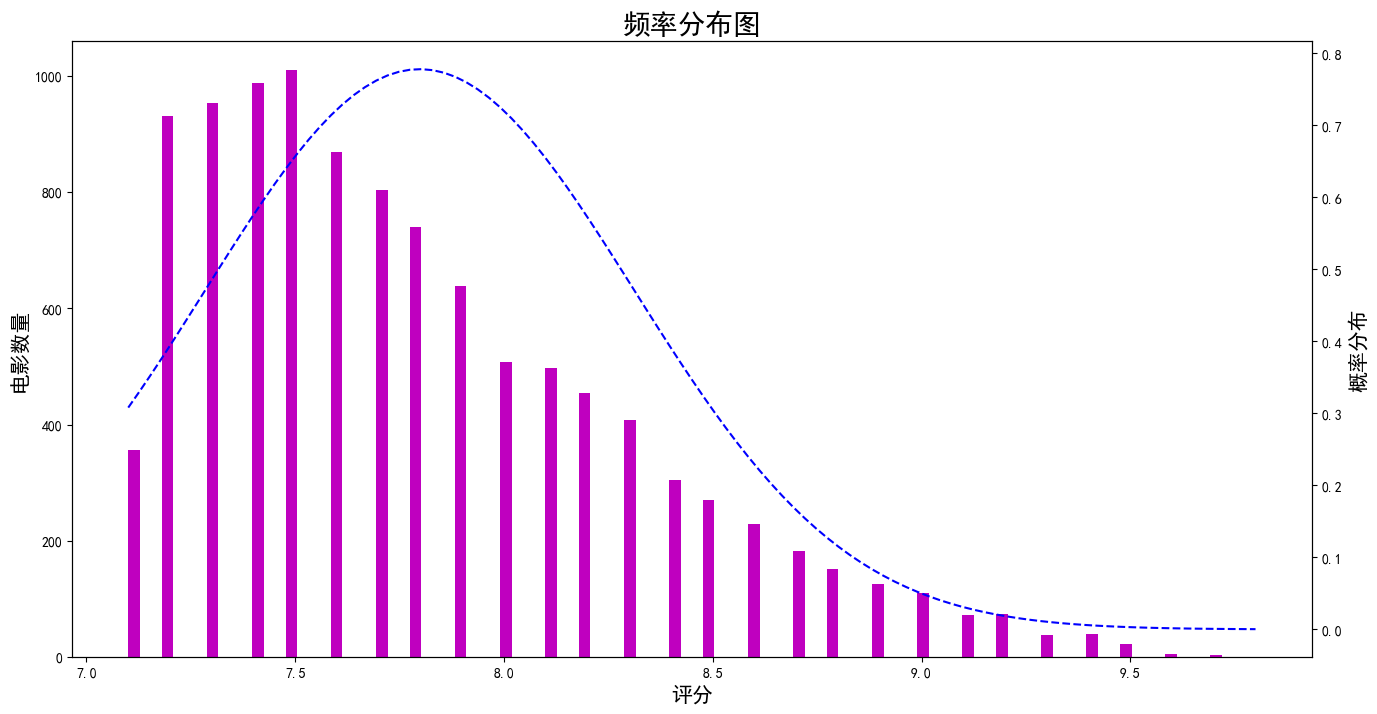

In [8]:
from scipy.stats import norm # 获取正态分布密度函数
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111) # 确认子图

n,bins,patches = ax1.hist(df["rating"],bins = 100, color = 'm') # bins默认是10

ax1.set_ylabel("电影数量",fontsize = 15)
ax1.set_xlabel("评分",fontsize = 15)
ax1.set_title("频率分布图",fontsize = 20)

#准备拟合
y = norm.pdf(bins,df["rating"].mean(),df["rating"].std()) # bins,mu,sigma
ax2 = ax1.twinx() # 双轴
ax2.plot(bins,y,"b--")
ax2.set_ylabel("概率分布",fontsize = 15)
plt.show()

### 根据电影时长和电影评分绘制散点图

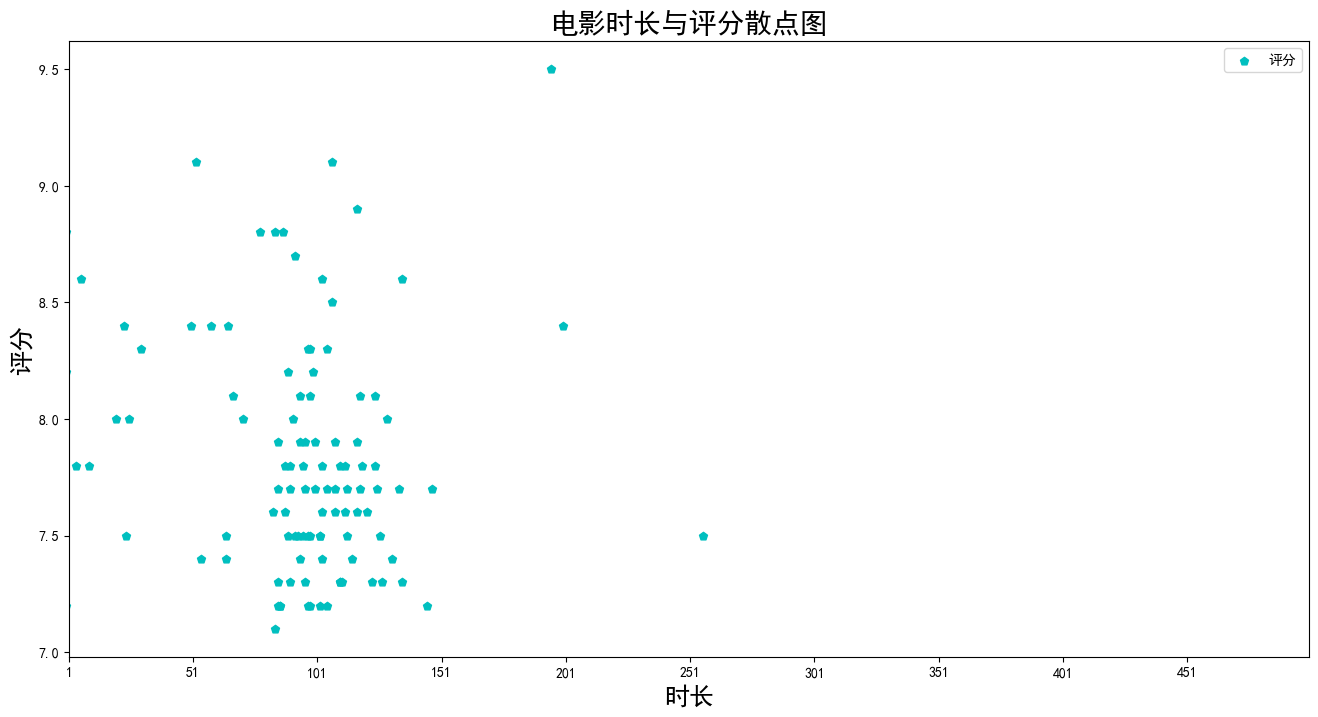

In [9]:
x = df["duration"][::100] 
y = df["rating"][::100]  # 解决数据冗杂的问题

plt.figure(figsize = (16,8))
plt.scatter(x,y,color = 'c',marker = 'p',label = "评分")
plt.xlim(1, 500)
plt.xticks(range(1, 501, 50))
plt.legend() # 图例
plt.title("电影时长与评分散点图",fontsize = 20)
plt.xlabel("时长",fontsize = 18)
plt.ylabel("评分",fontsize = 18)
plt.show()

### 分析电影的类型

In [10]:
# 对电影类型进行切割
movie_type = df['category'].str.split('/')
# 将列表转为Series
movie_type = movie_type.apply(pd.Series)
movie_type.head()
# 通过 unstack 函数将行旋转为列，重排数据：
movie_type = movie_type.apply(pd.value_counts)
movie_type.unstack()
# 此时数据为Series,去掉空值,并通过reset_index()转化为Dataframe
movie_type = movie_type.unstack().dropna().reset_index()
movie_type.head()
# 对电影类型汇总
movie_type.columns =['level_0','type','counts']
movie_type_m = movie_type.drop(['level_0'],axis=1).groupby('type').sum().sort_values(by=['counts'],ascending=False).reset_index()


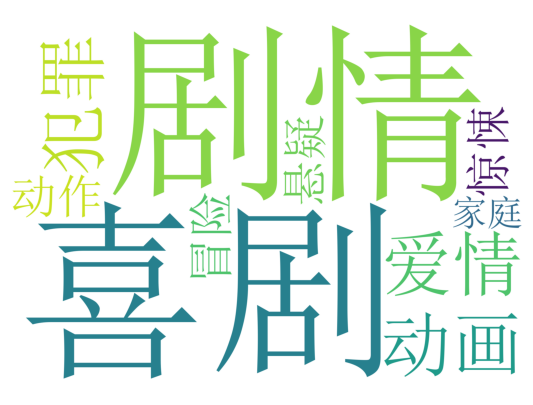

In [11]:
# 导入绘制树地图包
import squarify
# 导入绘制词云包
import wordcloud  

txt = ' '.join(movie_type_m['type'][:10])

w=wordcloud.WordCloud(
    width=2000,font_path="C:\\Windows\\Fonts\\simsun.ttc",height=1500, background_color="white"
)
w.generate(txt)
plt.figure(figsize = (15,5))
plt.imshow(w)
plt.axis('off')
plt.show()

## 处理数据

In [22]:
df['lables']

0         882
1         811
2         291
3         983
4          57
         ... 
10777     129
10778    1938
10779    2004
10780    1987
10781     852
Name: lables, Length: 10782, dtype: int64

In [23]:
missing_values = df['lables'].isnull().sum()
missing_values

0

In [24]:
df['lables'].nunique()

2498

In [25]:
lables=df['lables']

In [36]:
# 中文分词
movie_synopses = [' '.join(jieba.cut(s)) for s in df['des']]

# 将电影简介转换成整数序列
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(movie_synopses)
sequences = tokenizer.texts_to_sequences(movie_synopses)

# 对序列进行填充，以使它们具有相同的长度
maxlen = 50
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [35]:
padded_sequences

array([[  7,   2, 597, ...,   2, 171,   3],
       [  1,  15,   1, ..., 170,  11,   3],
       [160,  51, 161, ...,   2, 480,   3],
       ...,
       [  0,   0,   0, ...,   0,   0, 965],
       [  8,   7,   1, ...,   8,   7,   3],
       [246,  67, 941, ...,  10,   2,   3]], dtype=int32)

In [37]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, lables, test_size=0.2, random_state=42)

print("Training set shapes: ", X_train.shape, y_train.shape)
print("Testing set shapes: ", X_test.shape, y_test.shape)

Training set shapes:  (8625, 50) (8625,)
Testing set shapes:  (2157, 50) (2157,)


In [38]:
y_train = to_categorical(y_train, num_classes=2500)
y_test = to_categorical(y_test, num_classes=2500)

In [39]:
lables = to_categorical(lables, num_classes=2500)

In [40]:
maxlen = 50  
input_dim = 50000  
output_dim = 2500 # 输出维度为整个数据集中的电影种类数



> **cnn模型**





In [41]:
# 定义模型
model1 = Sequential()
model1.add(Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(units=output_dim, activation='softmax'))

# 编译模型
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 打印模型概要
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2500)              3842500   
                                                                 
Total params: 10,267,140
Trainable params: 10,267,140
Non-trainable params: 0
____________________________________________

In [42]:
history1 = model1.fit(padded_sequences, lables, epochs=50, batch_size=8)

Epoch 1/50
1348/1348 [==============================] - 33s 22ms/step - loss: 7.5174 - accuracy: 0.0066
Epoch 2/50
1348/1348 [==============================] - 10s 7ms/step - loss: 6.5695 - accuracy: 0.0142
Epoch 3/50
1348/1348 [==============================] - 9s 7ms/step - loss: 4.4668 - accuracy: 0.2060
Epoch 4/50
1348/1348 [==============================] - 9s 6ms/step - loss: 2.3802 - accuracy: 0.5418
Epoch 5/50
1348/1348 [==============================] - 10s 7ms/step - loss: 1.4665 - accuracy: 0.7066
Epoch 6/50
1348/1348 [==============================] - 10s 7ms/step - loss: 1.0986 - accuracy: 0.7820
Epoch 7/50
1348/1348 [==============================] - 9s 6ms/step - loss: 0.9302 - accuracy: 0.8134
Epoch 8/50
1348/1348 [==============================] - 8s 6ms/step - loss: 0.8204 - accuracy: 0.8265
Epoch 9/50
1348/1348 [==============================] - 7s 5ms/step - loss: 0.7542 - accuracy: 0.8346
Epoch 10/50
1348/1348 [==============================] - 8s 6ms/step - loss: 

In [59]:
model1= load_model('/content/drive/MyDrive/ITproject/cnn_model.h5')

In [60]:
# synopsis_model1 =str(df[df['id']==2]['des'])

# print(df[df['id']==2]['label'])

synopsis_model1='阿萨v自行车VS的发货问题'

synopsis_model1 = ' '.join(jieba.cut(synopsis_model1))
sequence_model1 = tokenizer.texts_to_sequences([synopsis_model1])
print(sequence_model1)
padded_sequence_model1 = pad_sequences(sequence_model1, maxlen=50)

pred = model1.predict(padded_sequence_model1)

pred_class = np.argmax(pred)

predicted_label = df[df['lables'] == pred_class]

print('预测的电影为:' )
print(predicted_label['name'],predicted_label['label'])

[[2, 365]]
1/1 [==============================] - 0s 58ms/step
预测的电影为:
7521     周六夜现场：科林·费尔斯/诺拉·琼斯
8382                   带我回家
8539               妄想学生会OAD
9437             妖精的尾巴 OAD6
9479          史上最强弟子兼一：美丽之翼
10761     关于我转生变成史莱姆这档事 OAD
Name: name, dtype: object 7521     ColinFirth/SNL/美国/喜剧/NorahJones/NBC/美剧/周六夜现场
8382                   公路/美国/爱情/喜剧/美国电影/浪漫爱情轻喜剧/剧情/独立
8539                    OAD/动画/日本/日本动画/搞笑/动漫/OVA/2011
9437                  OAD/日本/动画/动漫/2013/日本动画/アニメ/日本动漫
9479                    动漫/OVA/日本/日本动画/动画/OAD/2013/格斗
10761         OAD/日本动画/日本/动画/动漫/2019/転生したらスライムだった件/冒险
Name: label, dtype: object


In [55]:
model1.save('/content/drive/MyDrive/ITproject/cnn_model.h5')

In [57]:
# 定义模型
model2 = Sequential()
model2.add(Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen))
model2.add(LSTM(units=128))
model2.add(Dense(units=2500, activation='softmax'))

# 编译模型
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 2500)              322500    
                                                                 
Total params: 6,854,084
Trainable params: 6,854,084
Non-trainable params: 0
_________________________________________________________________


In [61]:
# 训练模型
history = model2.fit(padded_sequences, lables, epochs=50, batch_size=8)

Epoch 1/50
1348/1348 [==============================] - 29s 19ms/step - loss: 7.5789 - accuracy: 0.0055
Epoch 2/50
1348/1348 [==============================] - 12s 9ms/step - loss: 7.1944 - accuracy: 0.0107
Epoch 3/50
1348/1348 [==============================] - 10s 8ms/step - loss: 6.9521 - accuracy: 0.0136
Epoch 4/50
1348/1348 [==============================] - 11s 8ms/step - loss: 6.6206 - accuracy: 0.0176
Epoch 5/50
1348/1348 [==============================] - 11s 8ms/step - loss: 6.1593 - accuracy: 0.0302
Epoch 6/50
1348/1348 [==============================] - 11s 8ms/step - loss: 5.6168 - accuracy: 0.0547
Epoch 7/50
1348/1348 [==============================] - 10s 7ms/step - loss: 5.0419 - accuracy: 0.1090
Epoch 8/50
1348/1348 [==============================] - 10s 8ms/step - loss: 4.4687 - accuracy: 0.1834
Epoch 9/50
1348/1348 [==============================] - 10s 8ms/step - loss: 3.9283 - accuracy: 0.2708
Epoch 10/50
1348/1348 [==============================] - 11s 8ms/step - 

In [69]:
from keras.models import load_model
model2= load_model('/content/drive/MyDrive/ITproject/lstm_model.h5')

In [66]:
tokenizer = Tokenizer(num_words=1000)

synopsis_model2 ='奇幻'

synopsis_model2 = ' '.join(jieba.cut(synopsis_model2))
sequence_model2 = tokenizer.texts_to_sequences([synopsis_model2])
padded_sequence_model2 = pad_sequences(sequence_model2, maxlen=50)

pred = model2.predict(padded_sequence_model2)

pred_class = np.argmax(pred)

predicted_label = df[df['lables'] == pred_class][:10]

print('预测的电影为:')
print( predicted_label['name'],predicted_label['label'])

1/1 [==============================] - 0s 19ms/step
预测的电影为:
6407     世界奇妙物语 05秋之特別篇
6410     世界奇妙物语 02春之特别篇
6411    世界奇妙物语  99秋之特别篇
6412     世界奇妙物语 98秋之特别篇
6413     世界奇妙物语 96秋之特别篇
6414     世界奇妙物语 95秋之特别篇
6415     世界奇妙物语 95春之特别篇
6416     世界奇妙物语 94秋之特别篇
6417    世界奇妙物语  94春之特别篇
6418    世界奇妙物语  94冬之特别篇
Name: name, dtype: object 6407       世界奇妙物语/看过的电视剧/日语标签/日剧/日本/世にも奇妙な物語/2005/SP
6410      世界奇妙物语/日剧/柏原崇/日本/世にも奇妙な物語/看过的电视剧/日语标签/日剧SP
6411       世界奇妙物语/日剧/看过的电视剧/日语标签/日本/世にも奇妙な物語/日剧SP/SP
6412      世界奇妙物语/日剧/日本/世にも奇妙な物語/看过的电视剧/日语标签/1998/电视剧
6413    世界奇妙物语/日剧/日本/世にも奇妙な物語/铃木保奈美/1996/看过的电视剧/日剧SP
6414      世界奇妙物语/日剧/日本/世にも奇妙な物語/1995/日剧SP/电视剧/看过的电视剧
6415      世界奇妙物语/日剧/日本/木村拓哉/世にも奇妙な物語/电视剧/日剧SP/看过的电视剧
6416        世界奇妙物语/日剧/日本/世にも奇妙な物語/看过的电视剧/日语标签/电视剧/SP
6417      世界奇妙物语/日本/日剧/世にも奇妙な物語/看过的电视剧/日语标签/电视剧/日剧SP
6418        世界奇妙物语/日剧/日本/世にも奇妙な物語/电视剧/1994/SP/看过的电视剧
Name: label, dtype: object


In [67]:
model2.save('/content/drive/MyDrive/ITproject/lstm_model.h5')

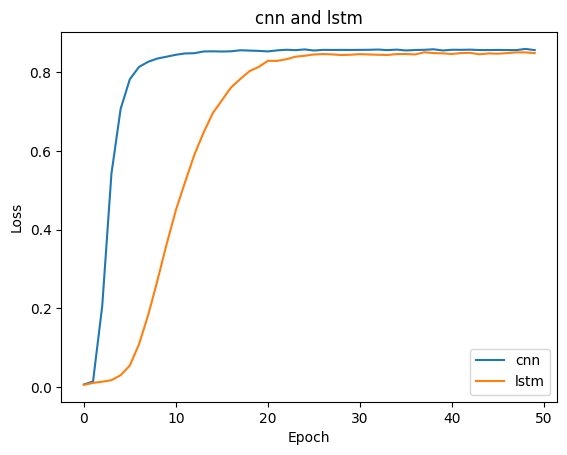

In [68]:
plt.plot(history1.history['accuracy'], label='cnn')
plt.plot(history.history['accuracy'], label='lstm')
plt.title('cnn and lstm')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()